In [22]:
# August 6, 2023; Nick Schaum

# This notebook takes as input all ITP data from 2004-2017 that I have concatenated into one file.
# It then plots the control data as a Kaplan-Meier curve and calculates some statistics
# The goal is to understand what the average HET3 lifespan is, and the variability in lifespan
# in order to perform power analysis for designing a new lifespan experiment
# and to create a 

### IMPORT REQUIRED PACKAGES AND DATA
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, WeibullFitter
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from lifelines.statistics import logrank_test
from scipy.interpolate import interp1d

# Read concatenated and cleaned raw data file
data_path = 'C:\\Users\\ndsch\\Data\\ITP-Lifespan-Data\\ITP_processed_data\\ITP_2004-2017_concat.csv'
df = pd.read_csv(data_path)

# Read the logrank data
#logrank_data_path = 'C:\\Users\\ndsch\\Data\\ITP-Lifespan-Data\\ITP_processed_data\\ITP_logrank.csv'
#logrank_df = pd.read_csv(logrank_data_path)

Median Survival Time: 848.0 days
Maximum Survival Time: 1456 days
90th Percentile Survival Time: 1081.48 days
Weibull Survival Formula: S(t) = exp(-((t / 901.39) ** 4.45))


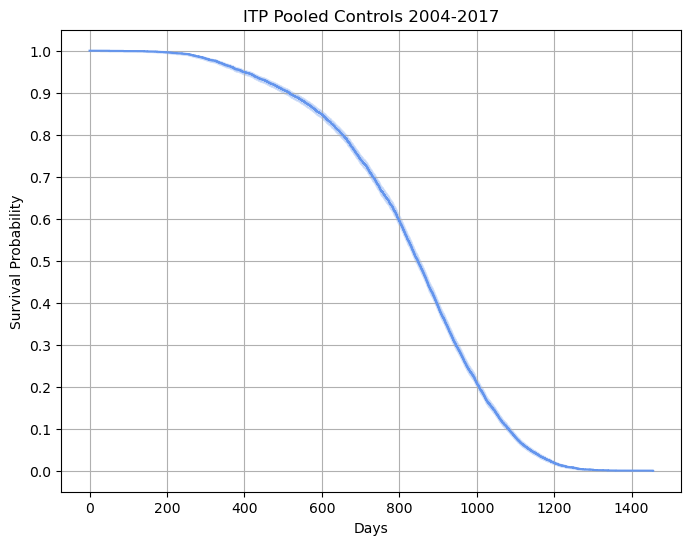

In [55]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, WeibullFitter
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from lifelines.statistics import logrank_test
from scipy.interpolate import interp1d
import scipy.stats as stats

# Read concatenated and cleaned raw data file
data_path = 'C:\\Users\\ndsch\\Data\\ITP-Lifespan-Data\\ITP_processed_data\\ITP_2004-2017_concat.csv'
df = pd.read_csv(data_path)

# Plot all control data in one Kaplan Meier curve

# Step 1: Filter data for control treatment
control_df = df[df['treatment'] == 'Control']

#Optional filter for a specific cohort like C2004
#control_df = control_df[control_df['cohort'] == 'C2004']

# Step 2: Initialize KaplanMeierFitter
kmf = KaplanMeierFitter()

# Step 3: Fit data to KaplanMeierFitter
# NOTE THAT THIS EXCLUDES status=removed
kmf.fit(durations=control_df['age(days)'], event_observed=control_df['dead'])

# Step 4: Plot the Kaplan-Meier curve
plt.figure(figsize=(8, 6))
kmf.plot(color='cornflowerblue')
plt.legend().remove()
plt.title('ITP Pooled Controls 2004-2017')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid()

# Step 5: Calculate the median and maximum survival
median_survival_time = kmf.median_survival_time_
maximum_survival_time = control_df['age(days)'].max()
print(f"Median Survival Time: {median_survival_time} days")
print(f"Maximum Survival Time: {maximum_survival_time} days")

# Step 6: Calculate the value of days corresponding to a survival probability of 0.9 (90th percentile)
desired_probability = 0.9
survival_probabilities = 1 - kmf.survival_function_.KM_estimate
survival_times = kmf.survival_function_.index
survival_prob_interp = interp1d(survival_probabilities, survival_times)
days_at_desired_prob = survival_prob_interp(desired_probability)
print(f"90th Percentile Survival Time: {days_at_desired_prob:.2f} days")

# Step 7: Fit a Weibull survival model to the data
weibull_model = WeibullFitter()
weibull_model.fit(durations=control_df['age(days)'], event_observed=control_df['dead'])

# Step 8: Get the parameters of the fitted Weibull model
scale_param = weibull_model.lambda_
shape_param = weibull_model.rho_

# Step 9: Output the formula of the Weibull survival function
print(f"Weibull Survival Formula: S(t) = exp(-((t / {scale_param:.2f}) ** {shape_param:.2f}))")


In [46]:
# Step 10: Calculate the required sample size (n) for Cox model
alpha = 0.05  # Significance level (e.g., 5%)
power = 0.80  # Desired power level (e.g., 80%)
Z_alpha = stats.norm.ppf(1 - alpha / 2)
Z_beta = stats.norm.ppf(power)
HR = 1.10  # For example, HR = 1.10 represents a 10% increase in lifespan

# Calculate the standard deviation (sigma) of the survival times
sigma = control_df['age(days)'].std()

# Calculate the required sample size (n)
n = (2 * (Z_alpha + Z_beta)**2 * (sigma**2)) / (HR**2)

print(f"Required Sample Size: {n:.2f} participants")
print(f"Sigma: {sigma:.2f}")

Required Sample Size: 711680.92 participants
Sigma: 234.22


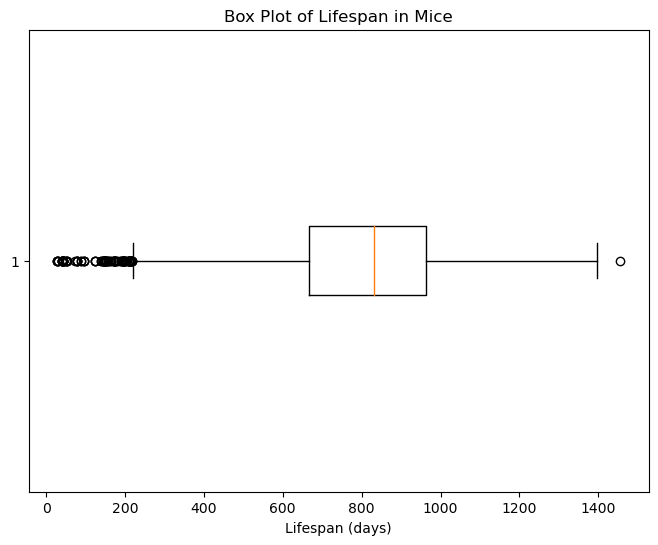

Summary Statistics for Lifespan Data:
--------------------------------------
Mean Lifespan: 799.04 days
Median Lifespan: 832.00 days
Standard Deviation: 233.79 days
Minimum Lifespan: 27 days
Maximum Lifespan: 1456 days


In [51]:
import matplotlib.pyplot as plt

# Assuming control_df['age(days)'] contains your lifespan data
lifespan_data = control_df['age(days)']

# Create a box plot
plt.figure(figsize=(8, 6))
plt.boxplot(lifespan_data, vert=False)
plt.xlabel('Lifespan (days)')
plt.title('Box Plot of Lifespan in Mice')
plt.show()


import numpy as np

# Assuming control_df['age(days)'] contains your lifespan data
lifespan_data = control_df['age(days)']

# Calculate relevant statistics
mean_lifespan = np.mean(lifespan_data)
median_lifespan = np.median(lifespan_data)
std_lifespan = np.std(lifespan_data)
min_lifespan = np.min(lifespan_data)
max_lifespan = np.max(lifespan_data)

# Print the statistics
print("Summary Statistics for Lifespan Data:")
print("--------------------------------------")
print(f"Mean Lifespan: {mean_lifespan:.2f} days")
print(f"Median Lifespan: {median_lifespan:.2f} days")
print(f"Standard Deviation: {std_lifespan:.2f} days")
print(f"Minimum Lifespan: {min_lifespan} days")
print(f"Maximum Lifespan: {max_lifespan} days")



In [60]:
# Create DataFrame for survival probabilities
days = np.arange(0, int(control_df['age(days)'].max()) + 1)  # Create an array of days
survival_probs = kmf.predict(days)
confidence_intervals = kmf.confidence_interval_

# Create a DataFrame to hold the survival probability values, confidence intervals, and days
survival_table = pd.DataFrame({
    'Days': days,
    'Survival Probability': survival_probs,
    'Lower CI': confidence_intervals['KM_estimate_lower_0.95'],
    'Upper CI': confidence_intervals['KM_estimate_upper_0.95']
})

# Print the survival table
print(survival_table)

# Export the survival table as a CSV file
csv_output_path = 'C:\\Users\\ndsch\\Data\\ITP-Lifespan-Data\\ITP_exported_data\\2004-2017_controls_survival_table.csv'
survival_table.to_csv(csv_output_path, index=False)
print(f"Survival table exported to {csv_output_path}")

        Days  Survival Probability  Lower CI  Upper CI
0.0        0               1.00000       1.0       1.0
1.0        1               1.00000       NaN       NaN
2.0        2               1.00000       NaN       NaN
3.0        3               1.00000       NaN       NaN
4.0        4               1.00000       NaN       NaN
...      ...                   ...       ...       ...
1452.0  1452               0.00014       NaN       NaN
1453.0  1453               0.00014       NaN       NaN
1454.0  1454               0.00014       NaN       NaN
1455.0  1455               0.00014       NaN       NaN
1456.0  1456               0.00000       0.0       0.0

[1457 rows x 4 columns]
Survival table exported to C:\Users\ndsch\Data\ITP-Lifespan-Data\ITP_exported_data\2004-2017_controls_survival_table.csv


In [65]:
### Mouse n Calculator
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import scipy.stats as stats

# Read concatenated and cleaned raw data file
data_path = 'C:\\Users\\ndsch\\Data\\ITP-Lifespan-Data\\ITP_processed_data\\ITP_2004-2017_concat.csv'
df = pd.read_csv(data_path)

# Filter data for control treatment
control_df = df[df['treatment'] == 'Control']

# Initialize KaplanMeierFitter
kmf = KaplanMeierFitter()

# Fit data to KaplanMeierFitter (exclude status=removed)
kmf.fit(durations=control_df['age(days)'], event_observed=control_df['dead'])

# Calculate survival probabilities and confidence intervals
days = np.arange(0, int(control_df['age(days)'].max()) + 1)
survival_probs = kmf.survival_function_.KM_estimate
confidence_intervals = kmf.confidence_interval_

def calculate_required_starting_mice(desired_mice_alive, start_age, end_age, confidence_level):
    # Find the indices corresponding to the start and end ages
    start_age_index = np.where(days == start_age)[0][0]
    end_age_index = np.where(days == end_age)[0][0]
    
    # Calculate survival probabilities between start and end ages
    survival_probs_interval = survival_probs[start_age_index:end_age_index + 1]
    
    # Calculate the hazard rates based on survival probabilities
    hazard_rates = -np.log(survival_probs_interval)
    
    # Calculate the cumulative hazard using numerical integration (e.g., Simpson's rule)
    cumulative_hazard = np.trapz(hazard_rates, dx=1)
    
    # Calculate the z-score corresponding to the desired confidence level
    z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)
    
    # Calculate the required initial number of mice
    required_initial_mice = desired_mice_alive / np.exp(cumulative_hazard)
    
    # Calculate the confidence interval bounds
    lower_bound = required_initial_mice / np.exp(z_score * np.sqrt(confidence_intervals['KM_estimate_lower_0.95'][end_age_index]))
    upper_bound = required_initial_mice / np.exp(z_score * np.sqrt(confidence_intervals['KM_estimate_upper_0.95'][end_age_index]))
    
    return required_initial_mice, lower_bound, upper_bound

# Example usage of the function
desired_mice_alive = 50
start_age = 183
end_age = 548
confidence_level = 0.95

required_initial_mice, lower_bound, upper_bound = calculate_required_starting_mice(
    desired_mice_alive, start_age, end_age, confidence_level)

print(f"Required Initial Mice: {required_initial_mice:.2f}")
print(f"Confidence Interval: {lower_bound:.2f} - {upper_bound:.2f}")

Required Initial Mice: 0.00
Confidence Interval: 0.00 - 0.00


In [78]:
import pandas as pd
import numpy as np
from lifelines import WeibullFitter
import scipy.stats as stats

# Read concatenated and cleaned raw data file
data_path = 'C:\\Users\\ndsch\\Data\\ITP-Lifespan-Data\\ITP_processed_data\\ITP_2004-2017_concat.csv'
df = pd.read_csv(data_path)

# Filter data for control treatment
control_df = df[df['treatment'] == 'Control']

# Initialize WeibullFitter
weibull_model = WeibullFitter()

# Fit Weibull survival model to the data
weibull_model.fit(durations=control_df['age(days)'], event_observed=control_df['dead'])

# Calculate the cumulative hazard using the cumulative hazard function from the Weibull model
cumulative_hazard_at_times = weibull_model.cumulative_hazard_at_times(control_df['age(days)']).values

# Calculate the cumulative hazard at the end age
end_age = 548
cumulative_hazard_at_end = cumulative_hazard_at_times[control_df['age(days)'] == end_age][0]

# Example input values
desired_mice_alive = 50
start_age = 183
confidence_level = 0.95

# Calculate the z-score corresponding to the desired confidence level
z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)

# Calculate the required initial number of mice using the formula
required_initial_mice = desired_mice_alive / np.exp(cumulative_hazard_at_end)

# Calculate the standard error of the cumulative hazard at the end age
se_cumulative_hazard = np.sqrt(np.cumsum(np.square(weibull_model.hazard_at_times(control_df['age(days)']))))[control_df['age(days)'] == end_age][0]

# Calculate the confidence interval bounds
lower_bound = required_initial_mice / np.exp(z_score * se_cumulative_hazard)
upper_bound = required_initial_mice * np.exp(z_score * se_cumulative_hazard)

print(f"Required Initial Mice: {required_initial_mice:.2f}")
print(f"Confidence Interval: {lower_bound:.2f} - {upper_bound:.2f}")


TypeError: Can't differentiate w.r.t. type <class 'pandas.core.series.Series'>